## Librearías

In [1]:
import uproot

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import awkward as ak

In [4]:
import vector

## Procesamiento de Datos

### Formato de Datos Tabular -> csv

Con Variables Para Filtros y para Entrenamiento

In [5]:
def procesar_muestra(filepath, sample_name, lep_max=2, jet_max=1, num_eventos=None):
    """
    Procesa un archivo ROOT con eventos de partículas y genera un CSV en formato tabular.

    Parámetros:
    -----------
    filepath : str
        Ruta del archivo ROOT a procesar.
    sample_name : str
        Nombre de la muestra (ej. 'Higgs', 'ttbar') que se agregará como columna 'sample'.
    lep_max : int, opcional
        Número máximo de leptones por evento que se expandirá en columnas separadas (default=2).
    jet_max : int, opcional
        Número máximo de jets por evento que se expandirá en columnas separadas (default=1).
    num_eventos : int o None, opcional
        Número de eventos a cargar. Si es None, se cargan todos los eventos del archivo.

    Salidas:
    --------
    df : pandas.DataFrame
        DataFrame tabular con las variables de interés aplanadas y filtradas, listo para análisis.
    """

    import uproot
    import awkward as ak
    import pandas as pd

    variables_interes = [
        'trigE', 'trigM',
        'lep_n', 'lep_pt', 'lep_eta', 'lep_phi',
        'lep_type', 'lep_charge', 'lep_ptcone30', 'lep_etcone20', 'lep_isTightID',
        'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 
        'jet_MV2c10',
        'met_et', 'met_phi'
    ]
    
    print(f"Procesando Señal: {sample_name} ...")
    print("LLevando a Formato Tabular")

    file = uproot.open(filepath)
    tree = file['mini;1']
    
    # Si num_eventos es None, se cargan todos
    if num_eventos is None:
        branches = tree.arrays(variables_interes)
        print(" → Cargando todos los eventos disponibles...")
    else:
        branches = tree.arrays(variables_interes, entry_stop=num_eventos)
        print(f" → Cargando los primeros {num_eventos} eventos...")

    # --- FILTRO: eventos con 0 0 1 jet ---
    mask = (branches['jet_n'] == 0) | (branches['jet_n'] == 1)
    #mask = branches['jet_n'] == 1
    filtered = branches[mask]

    data_dict = {}

    scalar_vars = ['trigE', 'trigM', 'lep_n', 'jet_n', 'met_et', 'met_phi']
    for var in scalar_vars:
        data_dict[var] = ak.to_numpy(filtered[var])

    lep_vars = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_charge', 'lep_type',
                'lep_ptcone30', 'lep_etcone20', 'lep_isTightID']
    for var in lep_vars:
        for i in range(lep_max):
            data_dict[f"{var}_{i}"] = ak.fill_none(ak.pad_none(filtered[var], lep_max)[:, i], 0).to_numpy()

    jet_vars = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_MV2c10']
    for var in jet_vars:
        data_dict[f"{var}"] = ak.fill_none(ak.pad_none(filtered[var], jet_max)[:, 0], 0).to_numpy()

    df = pd.DataFrame(data_dict)
    df["sample"] = sample_name

    #output_filename = f"datos_procesados_{sample_name}(PipeLine).csv"
    #df.to_csv(output_filename, index=False)

    total_eventos = len(df)
    #print(f" CSV guardado: {output_filename} ({total_eventos} eventos procesados)\n")
    print(f"({total_eventos} eventos procesados)\n")
    
    return df

### Filtros / Cortes

In [11]:
import numpy as np
import vector

def aplicar_cortes(df, nombre_salida_csv):
    """
    Aplica los cortes físicos al DataFrame.
    Devuelve un nuevo DataFrame filtrado con columnas adicionales:
      - mLL : masa invariante dileptónica [GeV]
      - pTll : impulso transversal del sistema dileptónico [GeV]
      - dphi_ll : Δφ entre los leptones
      - dphi_ll_met : Δφ entre sistema dileptónico y MET
    Además imprime un resumen con el conteo de eventos.
    """

    n_inicial = len(df)

    # --- 1. Trigger: evento con e o μ aislado
    mask_trigger = (df["trigE"] | df["trigM"])

    # --- 2. Leptones: exactamente dos de distinto sabor y signo opuesto
    mask_lep_n = (df["lep_n"] == 2)
    mask_charge = (df["lep_charge_0"] * df["lep_charge_1"] < 0)
    mask_flavor = (df["lep_type_0"] != df["lep_type_1"])

    # pT cortes (en MeV)
    mask_pt = (
        ((df["lep_type_0"] == 11) & (df["lep_pt_0"] > 22_000)) |  # e
        ((df["lep_type_0"] == 13) & (df["lep_pt_0"] > 15_000))
    ) & (
        ((df["lep_type_1"] == 11) & (df["lep_pt_1"] > 22_000)) |
        ((df["lep_type_1"] == 13) & (df["lep_pt_1"] > 15_000))
    )

    # Aislamiento e identificación estricta
    mask_iso = (
        (df["lep_etcone20_0"] < 0.1) & (df["lep_etcone20_1"] < 0.1) &
        (df["lep_ptcone30_0"] < 0.1) & (df["lep_ptcone30_1"] < 0.1) &
        (df["lep_isTightID_0"] == 1) & (df["lep_isTightID_1"] == 1)
    )

    # --- 3. Energía transversal faltante (MET)
    mask_met = (df["met_et"] > 30_000)

    # --- 4. Jets: ≤ 1 jet con pT>30 GeV y sin b-jets con pT>20 GeV
    mask_jet_n = (df["jet_n"] <= 1)
    mask_bjet_veto = ~((df["jet_pt"] > 20_000) & (df["jet_MV2c10"] > 0.5))
    mask_jets = mask_jet_n & mask_bjet_veto

    # --- 5. Cálculo de objetos vectoriales
    lep0 = vector.array({
        "pt": df["lep_pt_0"],
        "eta": df["lep_eta_0"],
        "phi": df["lep_phi_0"],
        "mass": np.zeros(len(df))
    })
    lep1 = vector.array({
        "pt": df["lep_pt_1"],
        "eta": df["lep_eta_1"],
        "phi": df["lep_phi_1"],
        "mass": np.zeros(len(df))
    })
    met = vector.array({
        "pt": df["met_et"],
        "eta": np.zeros(len(df)),
        "phi": df["met_phi"],
        "mass": np.zeros(len(df))
    })

    # --- Cálculos cinemáticos
    dilepton = lep0 + lep1
    df["mLL"] = dilepton.mass / 1000.0         # GeV
    df["pTll"] = dilepton.pt / 1000.0          # GeV
    df["dphi_ll"] = np.abs(lep0.deltaphi(lep1))
    df["dphi_ll_met"] = np.abs(dilepton.deltaphi(met))

    # --- 6. Ángulos azimutales y cortes cinemáticos
    mask_dphi = (df["dphi_ll_met"] > np.pi/2) & (df["dphi_ll"] < 1.8)
    mask_pTll = (df["pTll"] > 30)
    mask_mLL = (df["mLL"] > 10) & (df["mLL"] < 55)

    # --- Corte total combinado
    mask_total = (
        mask_trigger & mask_lep_n & mask_charge & mask_flavor &
        mask_pt & mask_iso & mask_met & mask_jets &
        mask_dphi & mask_pTll & mask_mLL
    )

    df_sel = df[mask_total].copy()
    n_final = len(df_sel)
    porcentaje = (n_final / n_inicial * 100) if n_inicial > 0 else 0.0
    
    # --- Guardar Datos en un csv
    output_filename = f"datos_filtrados_{nombre_salida_csv}.csv"
    df_sel.to_csv(output_filename, index=False)
    print(f" CSV guardado: {output_filename}\n")

    # --- Resumen
    print("---- Resumen de selección ----")
    print(f"Eventos iniciales: {n_inicial}")
    print(f"Eventos seleccionados: {n_final}")
    print(f"Porcentaje retenido: {porcentaje:.2f}%")
    print("-------------------------------")

    return df_sel


### Señales

In [12]:
# --- Higgs ---
# Procesar Muestra
df_Higgs = procesar_muestra('mc_345324.ggH125_WW2lep.exactly2lep.root', 'Higgs')
# Aplicar Filtros
df_Higgs_Filtrado = aplicar_cortes(df_Higgs, nombre_salida_csv='Higgs')

Procesando Señal: Higgs ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(448254 eventos procesados)

 CSV guardado: datos_filtrados_Higgs.csv

---- Resumen de selección ----
Eventos iniciales: 448254
Eventos seleccionados: 11340
Porcentaje retenido: 2.53%
-------------------------------


In [8]:
#df_Higgs_Filtrado[df_Higgs_Filtrado['jet_n']==0]

,trigE,trigM,lep_n,jet_n,met_et,met_phi,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,...,lep_isTightID_1,jet_pt,jet_eta,jet_phi,jet_MV2c10,sample,mLL,pTll,dphi_ll,dphi_ll_met
63,True,False,2,0,39022.519531,-1.089380,25781.666016,17113.576172,-0.452725,1.379291,...,1,0.0,0.0,0.0,0.0,Higgs,44.137601,42.849985,0.093817,2.952481
87,True,False,2,0,49008.417969,-2.178779,29257.076172,24934.916016,1.221104,0.095650,...,1,0.0,0.0,0.0,0.0,Higgs,34.043315,52.949233,0.430538,3.053860
102,True,False,2,0,47663.121094,-3.069983,36815.746094,26251.193359,-1.186642,-0.364178,...,1,0.0,0.0,0.0,0.0,Higgs,30.087913,61.348242,0.474824,2.140317
107,True,False,2,0,32825.667969,3.075138,29478.074219,16341.107422,-0.878886,0.460851,...,1,0.0,0.0,0.0,0.0,Higgs,35.181206,43.169468,0.714761,3.010315
183,True,False,2,0,49157.335938,-0.821221,42516.468750,18097.871094,-0.536787,-0.348545,...,1,0.0,0.0,0.0,0.0,Higgs,43.643721,42.387146,1.792579,2.707356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448125,True,True,2,0,45795.441406,0.570827,43804.343750,33383.062500,-1.174078,-0.496348,...,1,0.0,0.0,0.0,0.0,Higgs,51.630346,63.166286,1.237535,2.321912
448127,True,True,2,0,61031.117188,-1.104980,31511.583984,30336.847656,0.822397,1.569823,...,1,0.0,0.0,0.0,0.0,Higgs,24.578813,61.485639,0.216771,3.124570
448163,False,True,2,0,34746.121094,0.813728,29069.144531,24773.859375,0.408973,0.856449,...,1,0.0,0.0,0.0,0.0,Higgs,41.876297,35.945338,1.686790,3.108083
448183,True,False,2,0,45190.792969,1.963173,32363.181641,25330.203125,0.357383,1.321190,...,1,0.0,0.0,0.0,0.0,Higgs,36.337594,53.201604,0.800728,2.755751


In [13]:
# --- Diboson WW ---
# Procesar Muestra
df_WW = procesar_muestra('mc_363492.llvv.exactly2lep.root', 'WW')
# Aplicar Filtros
df_WW_Filtrado = aplicar_cortes(df_WW, nombre_salida_csv='DibosonWW')

Procesando Señal: WW ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(1801924 eventos procesados)

 CSV guardado: datos_filtrados_DibosonWW.csv

---- Resumen de selección ----
Eventos iniciales: 1801924
Eventos seleccionados: 14937
Porcentaje retenido: 0.83%
-------------------------------


In [14]:
# --- ttbar ---
# Procesar Muestra
df_ttbar = procesar_muestra('mc_410011.single_top_tchan.exactly2lep.root', 'ttbar')
# Aplicar Filtros
df_ttbar_Filtrado = aplicar_cortes(df_ttbar, nombre_salida_csv='ttbar')

Procesando Señal: ttbar ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(18110 eventos procesados)

 CSV guardado: datos_filtrados_ttbar.csv

---- Resumen de selección ----
Eventos iniciales: 18110
Eventos seleccionados: 1
Porcentaje retenido: 0.01%
-------------------------------


In [15]:
# --- Ztautau ---
# Procesar Muestra
df_Ztautau = procesar_muestra('mc_361108.Ztautau.exactly2lep.root', 'Ztautau')
# Aplicar Filtros
df_Ztautau_Filtrado = aplicar_cortes(df_Ztautau, nombre_salida_csv='Ztautau')

Procesando Señal: Ztautau ...
LLevando a Formato Tabular
 → Cargando todos los eventos disponibles...
(154618 eventos procesados)

 CSV guardado: datos_filtrados_Ztautau.csv

---- Resumen de selección ----
Eventos iniciales: 154618
Eventos seleccionados: 3
Porcentaje retenido: 0.00%
-------------------------------


### Número de Eventos

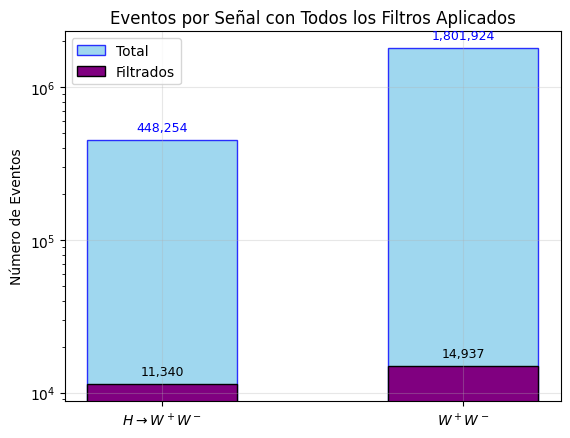

In [20]:
#import matplotlib.pyplot as plt

labels = [r'$H \rightarrow W^+W^-$', r'$W^+W^-$']
total_events = [448254, 1801924]
filtered_events = [11340, 14937]

# Barras totales (azules)
bars1 = plt.bar(labels, total_events, color='skyblue', width=0.5, edgecolor='blue', alpha=0.8, label='Total')
# Barras filtradas (moradas)
bars2 = plt.bar(labels, filtered_events, color='purple', width=0.5, edgecolor='black', alpha=1, label='Filtrados')

plt.ylabel('Número de Eventos')
plt.yscale('log')
plt.title('Eventos por Señal con Todos los Filtros Aplicados')
plt.grid(alpha=0.3)
plt.legend()

# Agregar etiquetas para cada conjunto
for bars, color in zip([bars1, bars2], ['blue', 'black']):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.1, f'{int(height):,}', 
                 ha='center', va='bottom', fontsize=9, color=color)

plt.show()



## Definición de Clases

Clase 0: `jet_n` == 0

Clase 1: `jet_n` == 1


In [22]:
# --- Clase 0 ---
df_Higgs_Clase0 = df_Higgs_Filtrado[df_Higgs_Filtrado['jet_n']==0]
df_WW_Clase0    = df_WW_Filtrado[df_WW_Filtrado['jet_n']==0]


# --- Clase 1 ---
df_Higgs_Clase1 = df_Higgs_Filtrado[df_Higgs_Filtrado['jet_n']==1]
df_WW_Clase1    = df_WW_Filtrado[df_WW_Filtrado['jet_n']==1]

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def comparar_distribuciones(df1, df2, nombre1='Muestra 1', nombre2='Muestra 2'):
    """
    Grafica comparaciones de distribuciones (KDE) entre dos DataFrames.

    Parámetros:
    -----------
    df1, df2 : pandas.DataFrame
        DataFrames que se desean comparar.
    nombre1, nombre2 : str
        Etiquetas para las leyendas de las gráficas (por ejemplo: 'Higgs', 'WW').
    """
    
    # Selecciona solo las columnas numéricas comunes a ambos DataFrames
    columnas = df1.select_dtypes(include=['number']).columns.intersection(
        df2.select_dtypes(include=['number']).columns
    )

    for col in columnas:
        plt.figure(figsize=(7, 4))
        
        sns.kdeplot(
            data=df1, x=col,
            fill=True, alpha=0.4, label=nombre1,
            common_norm=False
        )
        sns.kdeplot(
            data=df2, x=col,
            fill=True, alpha=0.4, label=nombre2,
            common_norm=False
        )

        plt.xlabel(col)
        plt.ylabel('Densidad normalizada')
        plt.title(f'Comparación de distribuciones: {col}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


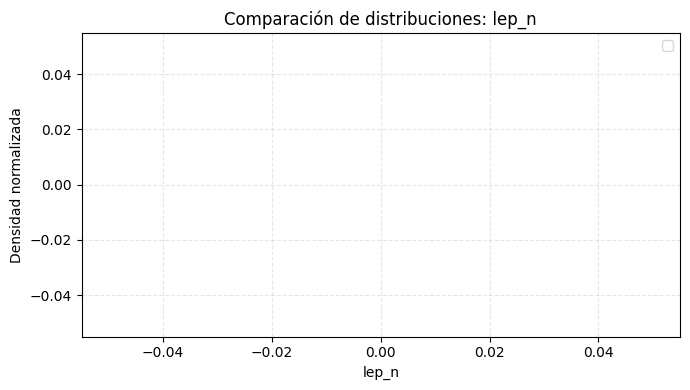

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


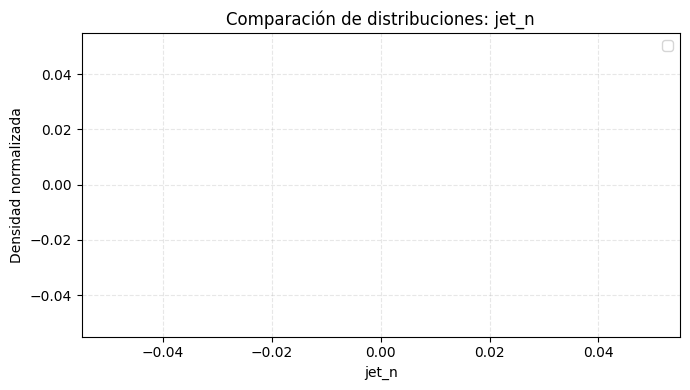

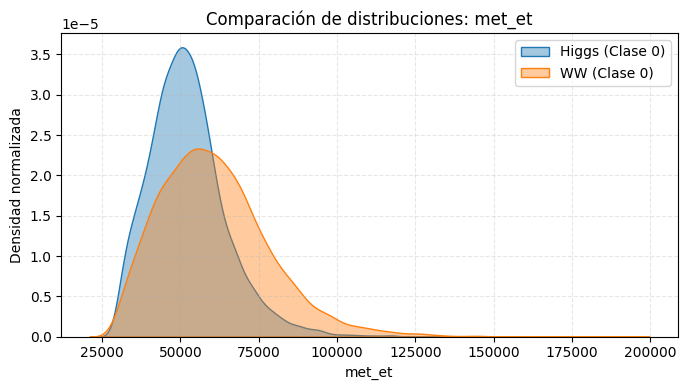

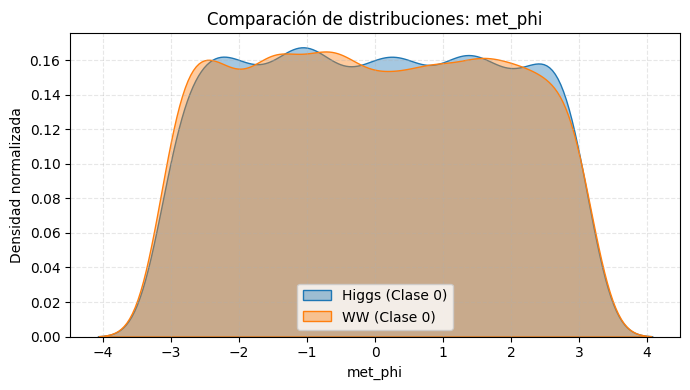

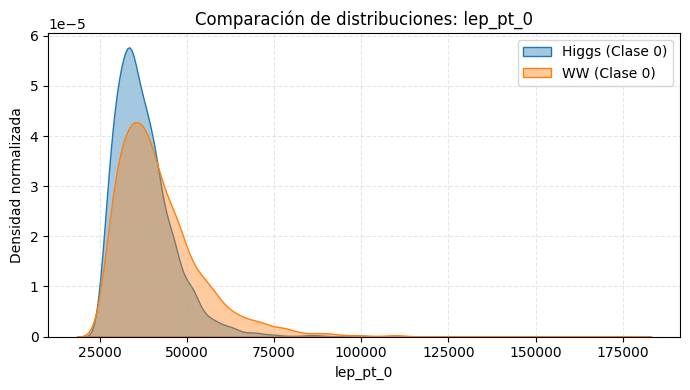

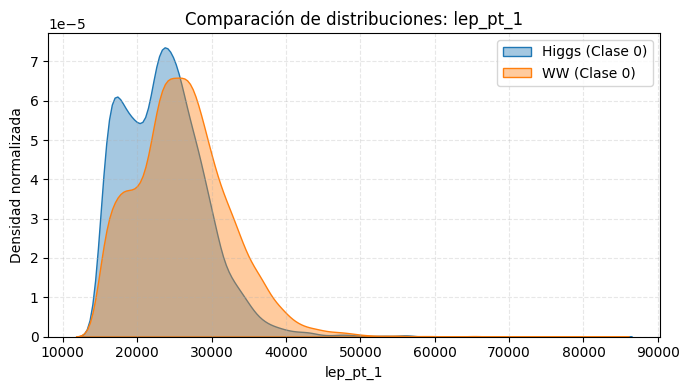

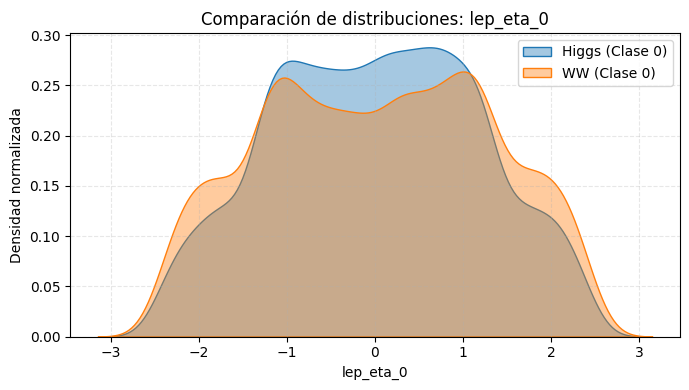

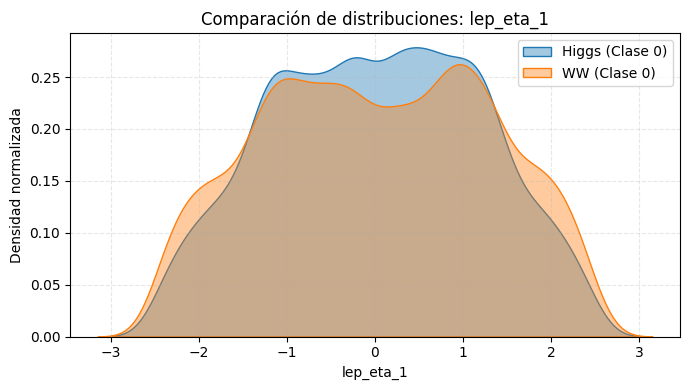

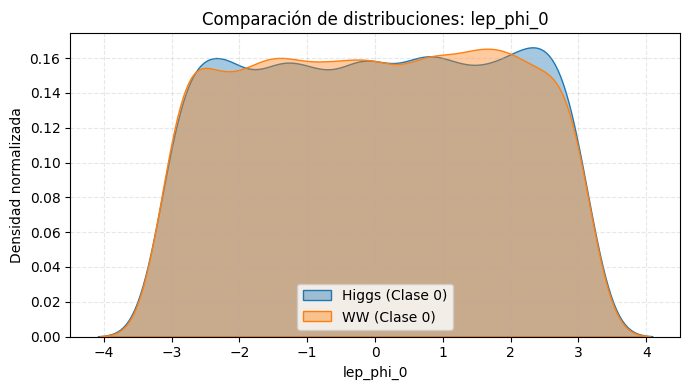

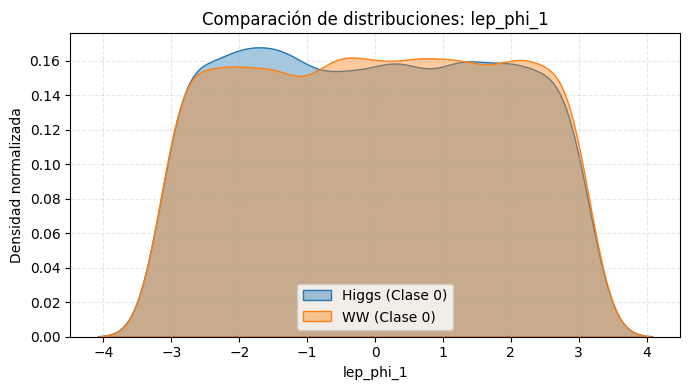

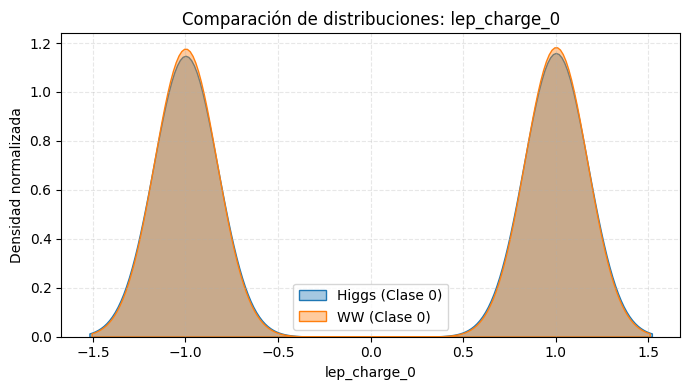

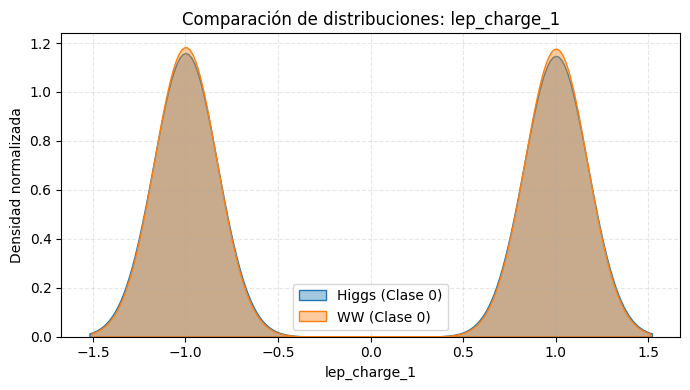

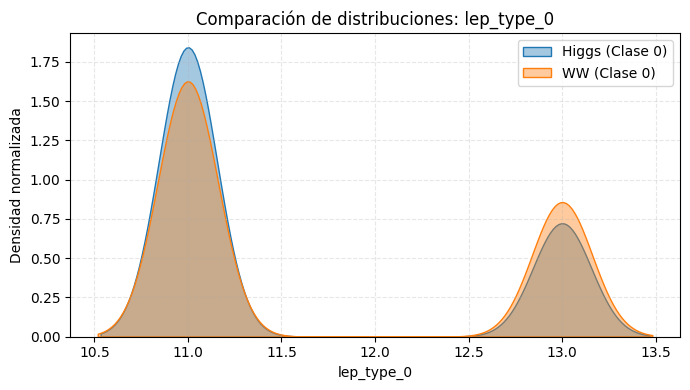

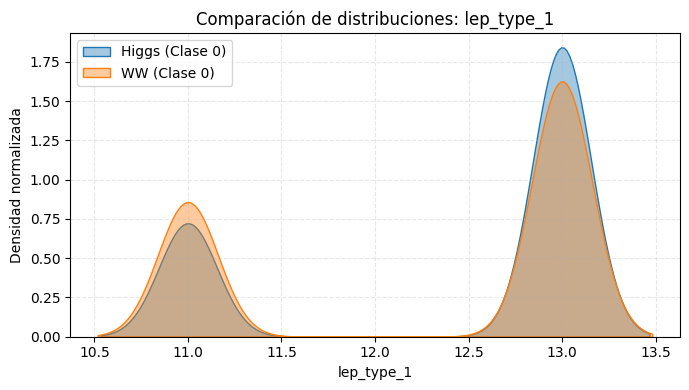

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


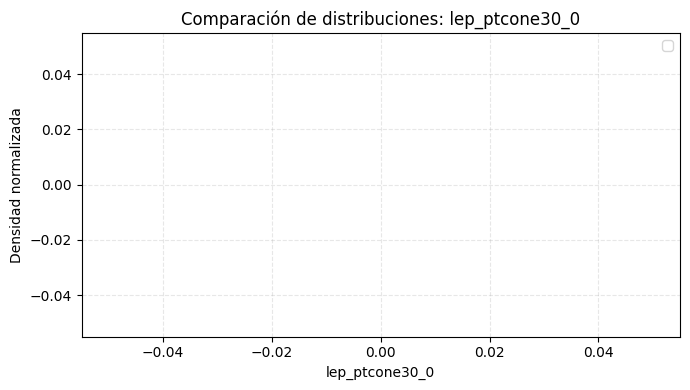

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


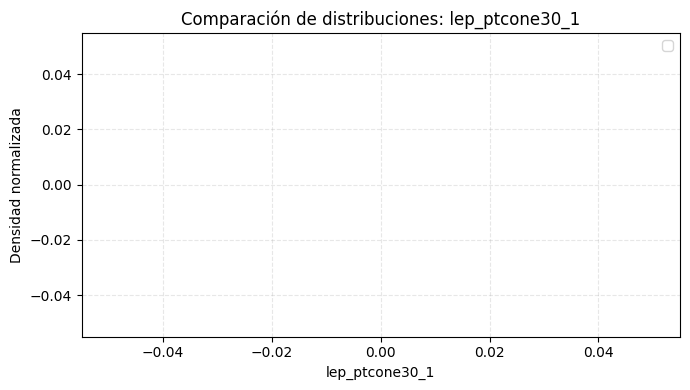

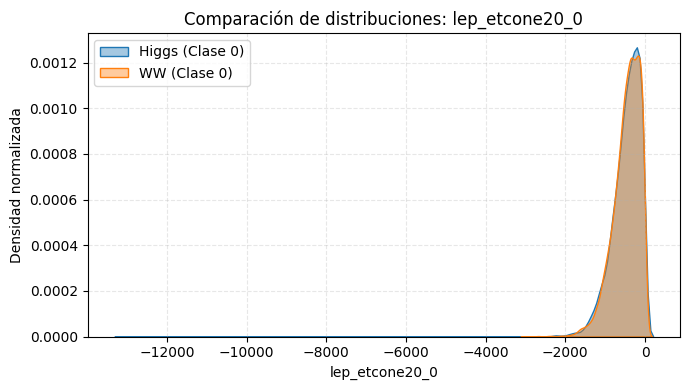

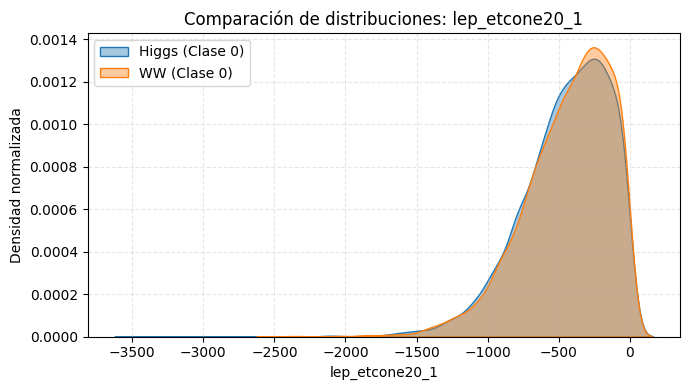

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


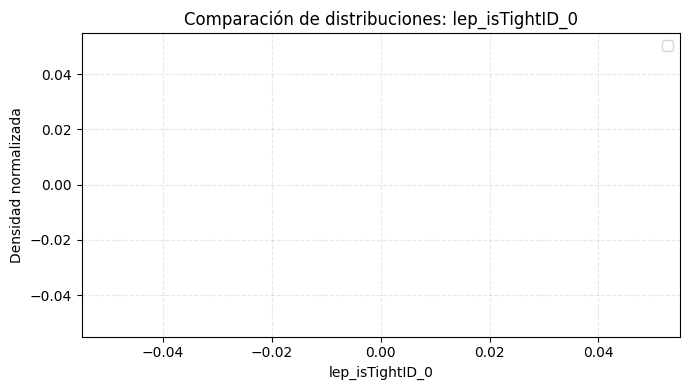

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


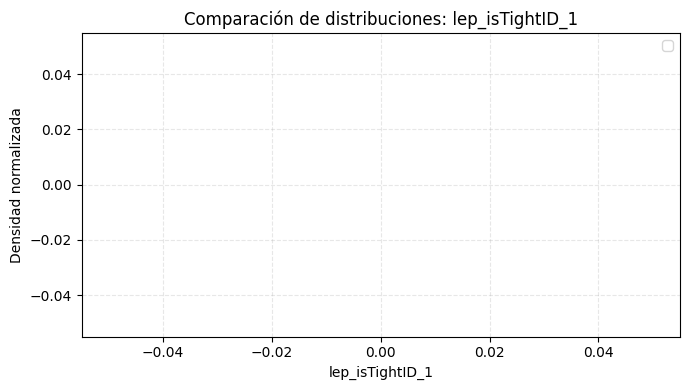

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


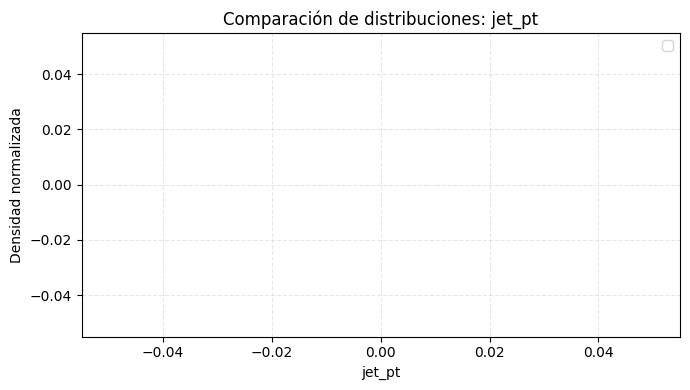

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


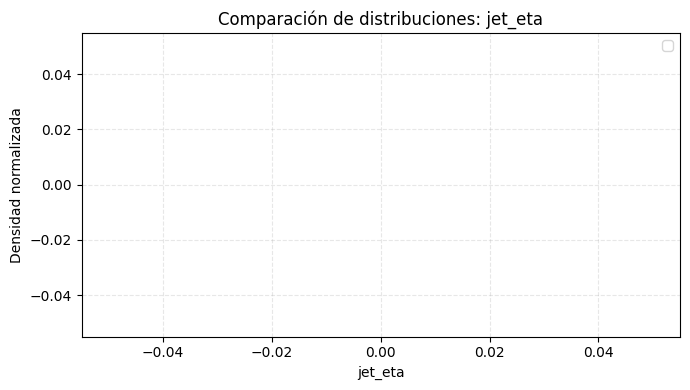

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


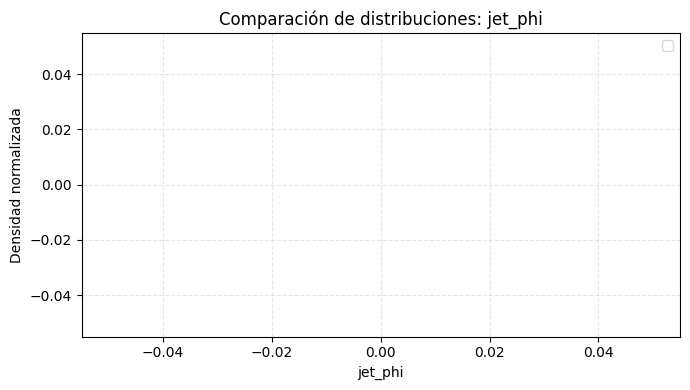

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


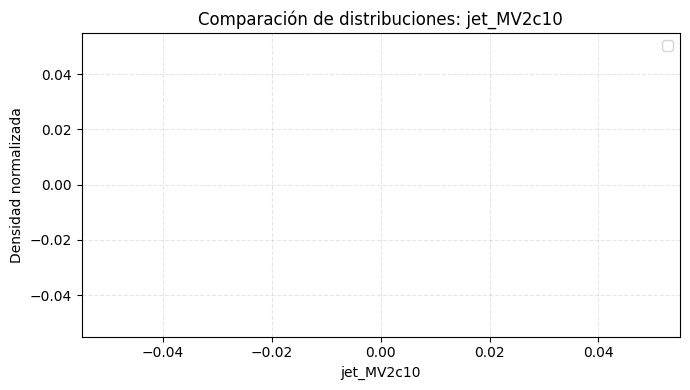

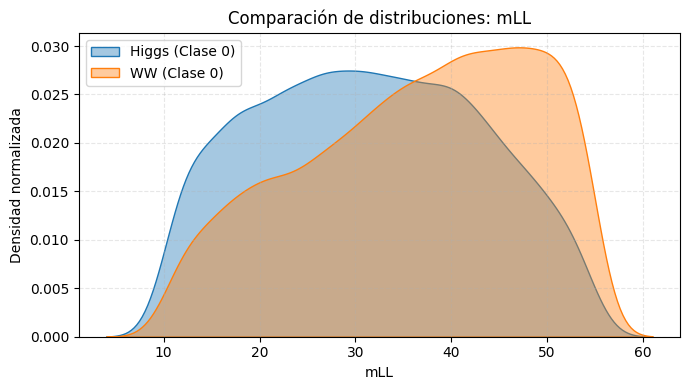

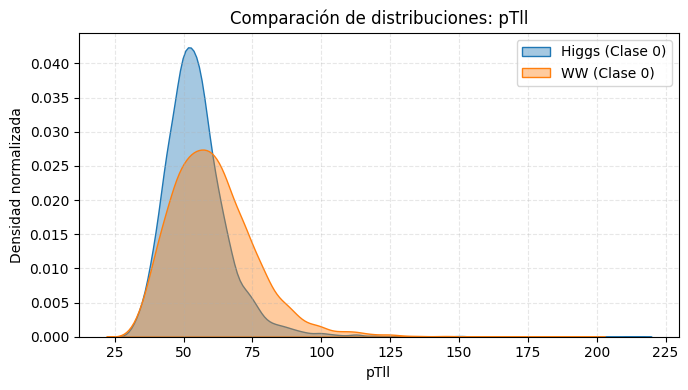

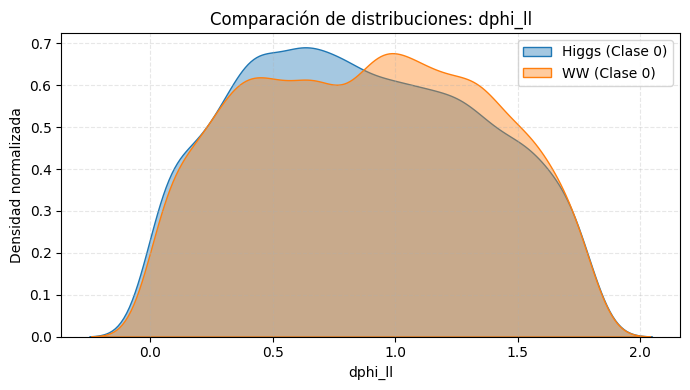

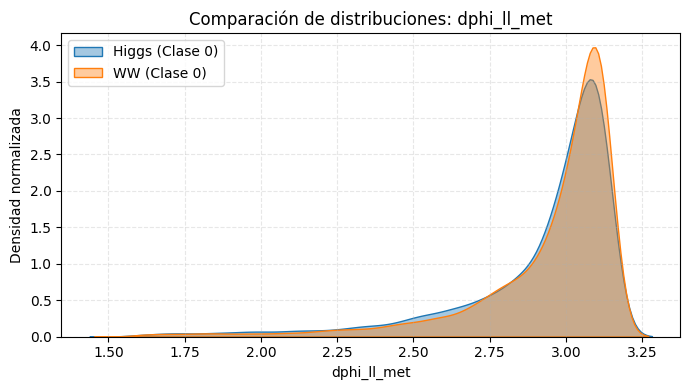

In [24]:
# Comparar clase 0
comparar_distribuciones(df_Higgs_Clase0, df_WW_Clase0, 'Higgs (Clase 0)', 'WW (Clase 0)')


/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


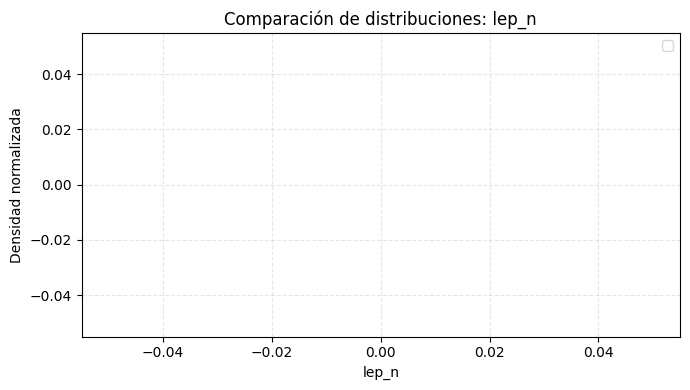

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


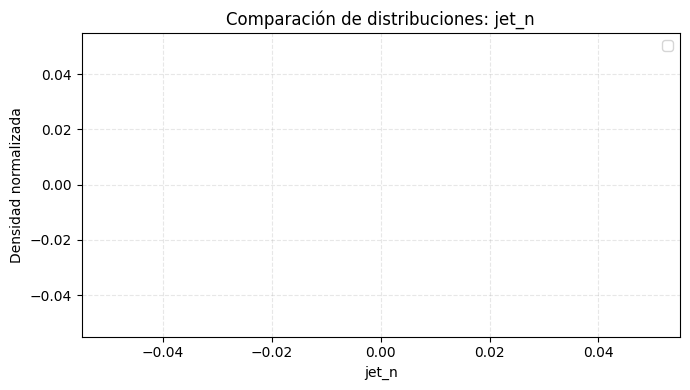

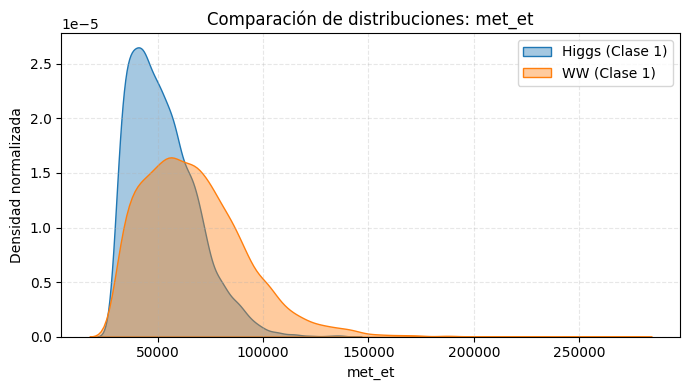

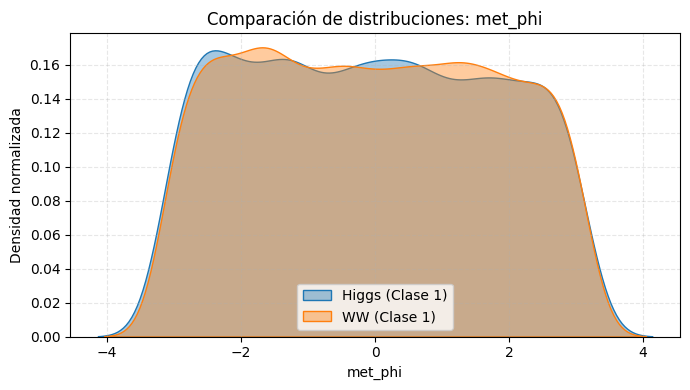

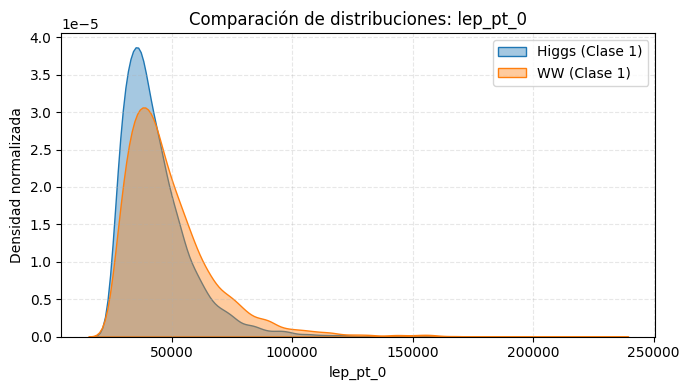

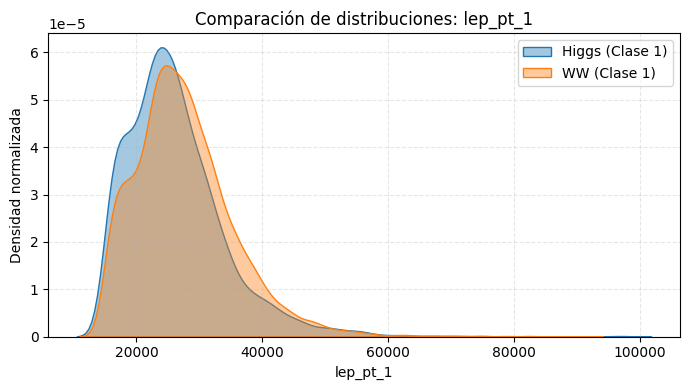

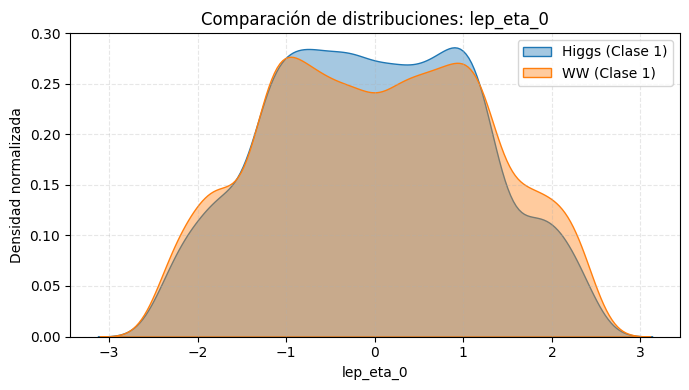

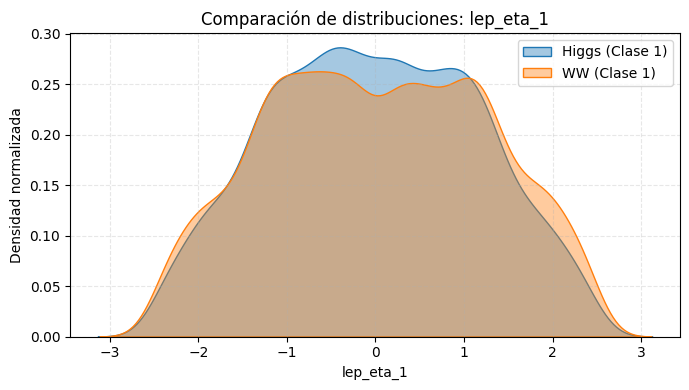

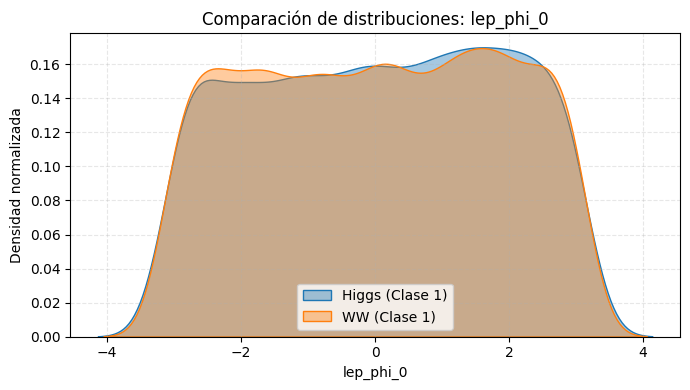

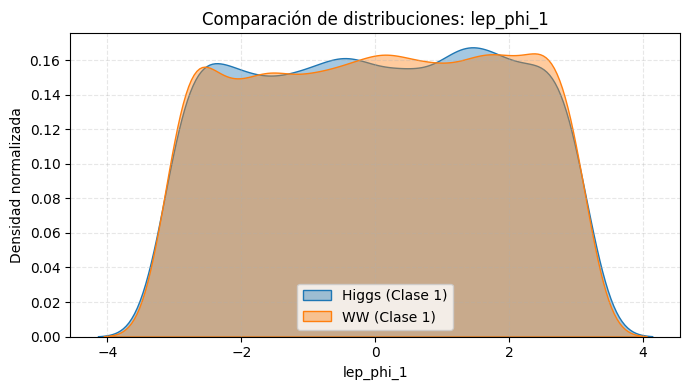

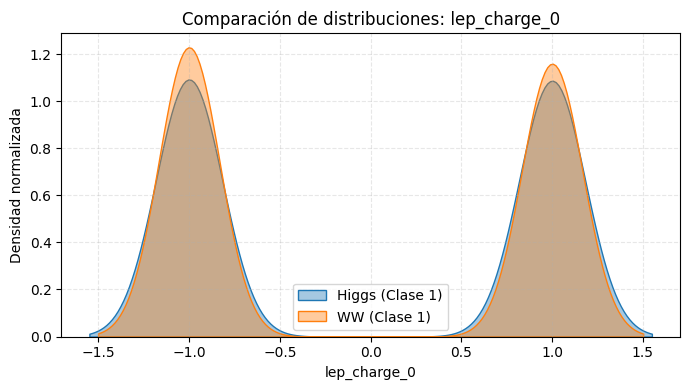

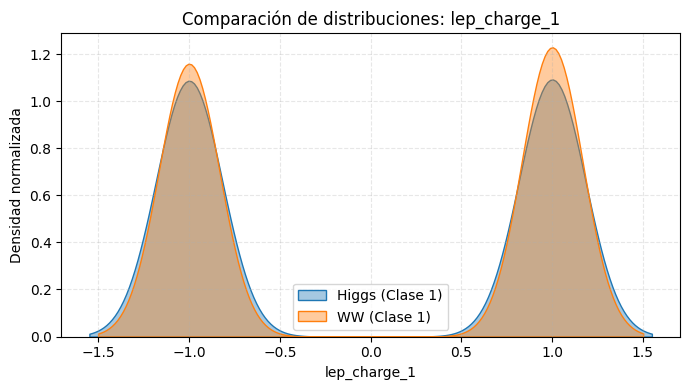

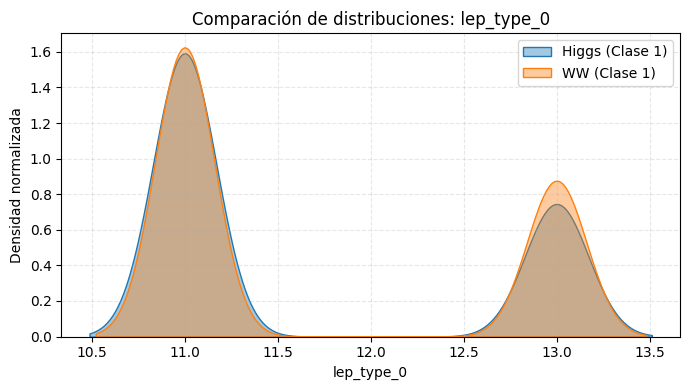

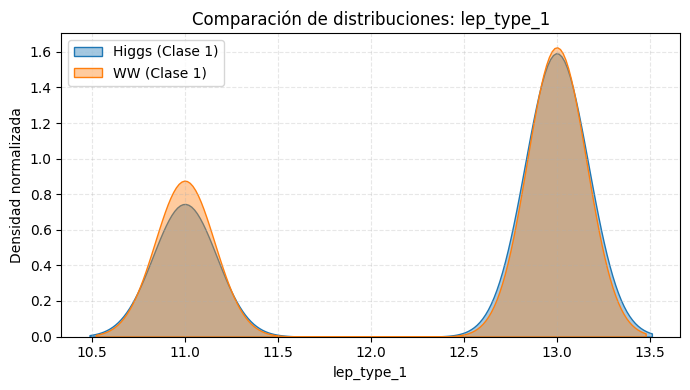

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


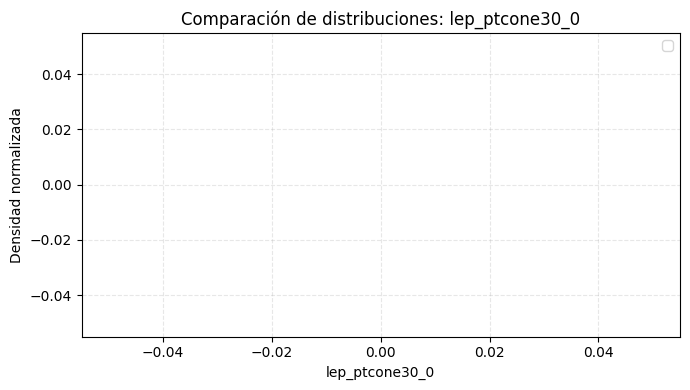

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


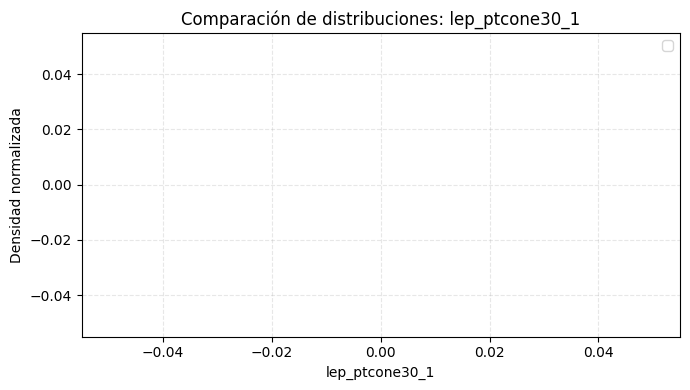

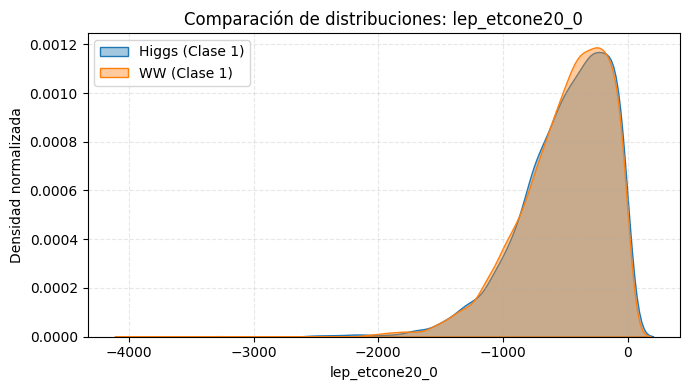

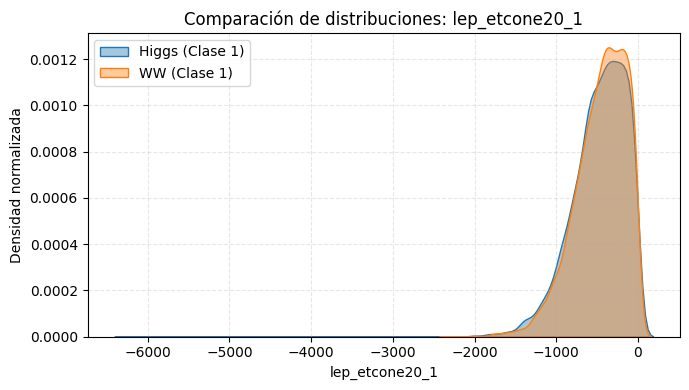

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


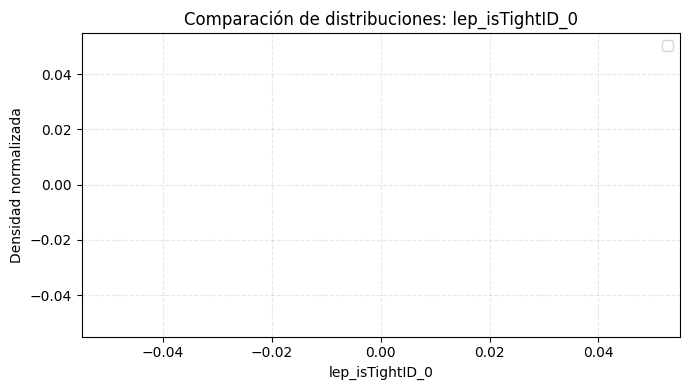

/tmp/ipykernel_20928/3714849487.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_20928/3714849487.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


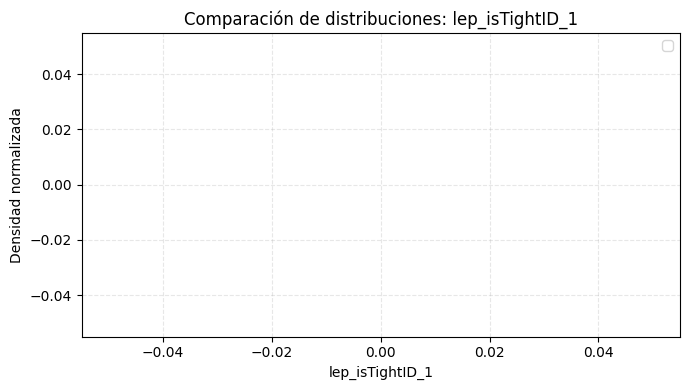

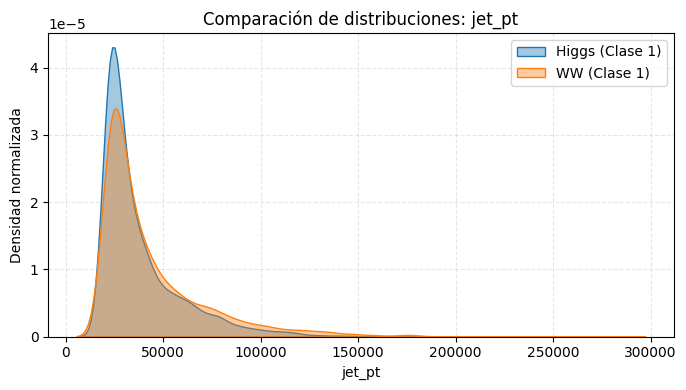

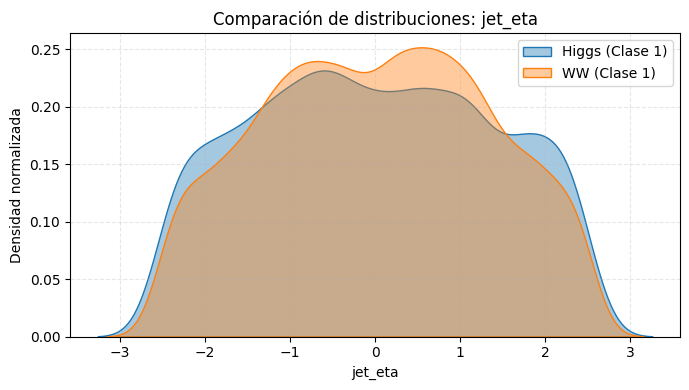

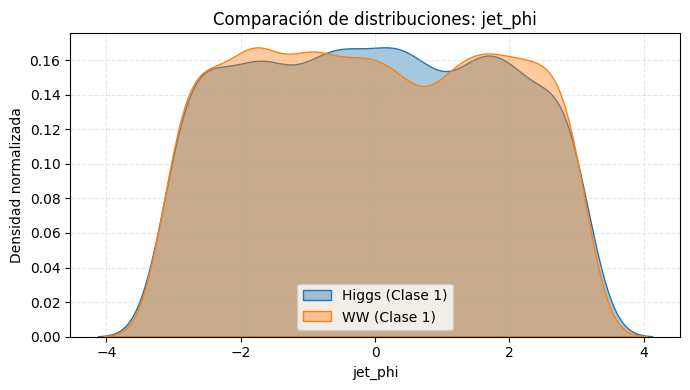

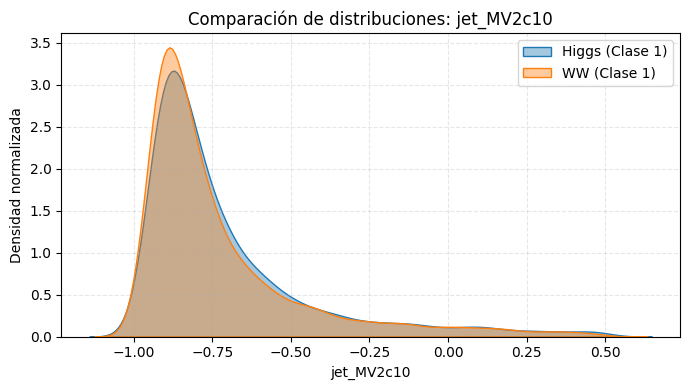

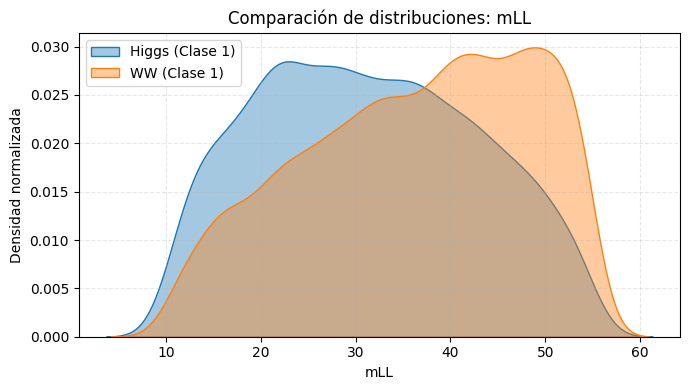

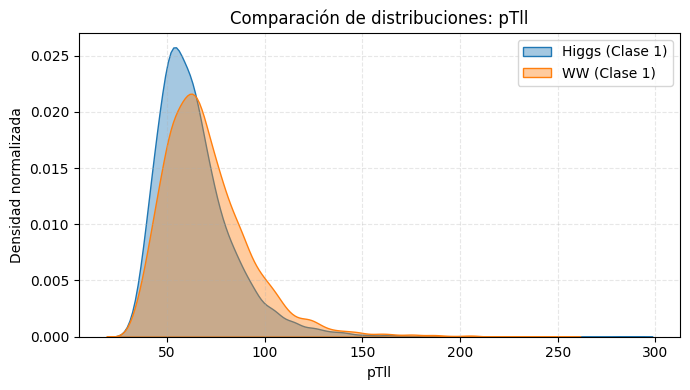

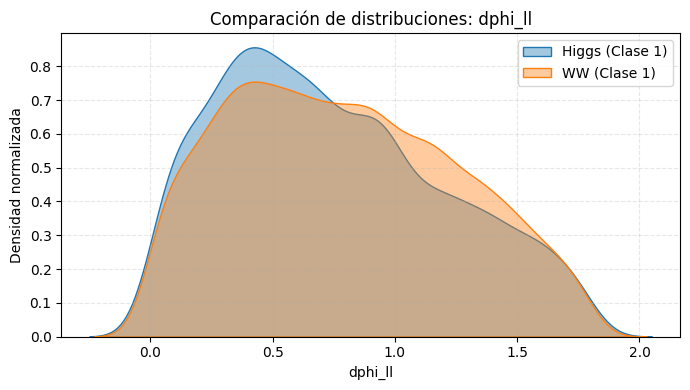

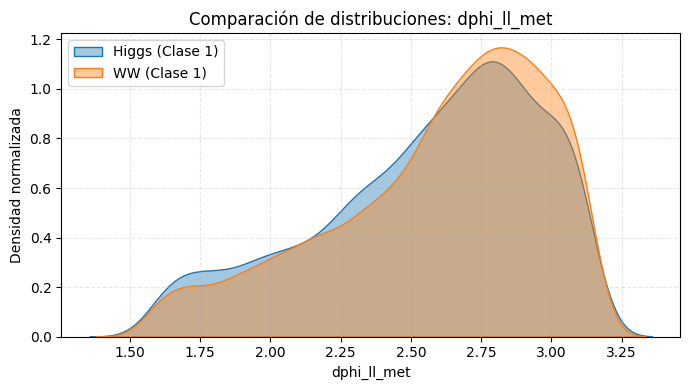

In [25]:
# Comparar clase 1
comparar_distribuciones(df_Higgs_Clase1, df_WW_Clase1, 'Higgs (Clase 1)', 'WW (Clase 1)')